Calculate Time Averages from Monthly Time Series
================================================

Author: [Tom Vo](https://github.com/tomvothecoder/)

Date: 05/27/22

Related APIs:

* [xarray.Dataset.temporal.average()](../generated/xarray.Dataset.temporal.average.rst)
* [xarray.Dataset.temporal.group_average()](../generated/xarray.Dataset.temporal.group_average.rst)

The data used in this example can be found through the [Earth System Grid Federation (ESGF) search portal](https://aims2.llnl.gov/metagrid/search).

## Overview

Suppose we have a netCDF4 file with monthly air temperature data (`tas`) from 1850-01-16 to 2014-12-16. 

We want to calculate averages with the time dimension removed (a single time snapshot), and averages by time group.

In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import xcdat


## 1. Open the `Dataset`

We are using xarray's OPeNDAP support to read a netCDF4 dataset file directly from its source. The data is not loaded over the network until we perform operations on it (e.g., temperature unit adjustment).

More information on the xarray's OpenDAP support can be found [here](https://docs.xarray.dev/en/stable/user-guide/io.html#opendap).

In [2]:
filepath = "http://esgf.nci.org.au/thredds/dodsC/master/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r10i1p1f1/Amon/tas/gn/v20200605/tas_Amon_ACCESS-ESM1-5_historical_r10i1p1f1_gn_185001-201412.nc"
ds = xcdat.open_dataset(filepath)

# Unit adjust (-273.15, K to C)
ds["tas"] = ds.tas - 273.15

ds

<xarray.Dataset>
Dimensions:    (time: 1980, bnds: 2, lat: 145, lon: 192)
Coordinates:
  * time       (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T12:00:00
  * lat        (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * lon        (lon) float64 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
    height     float64 2.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] ...
    lat_bnds   (lat, bnds) float64 ...
    lon_bnds   (lon, bnds) float64 ...
    tas        (time, lat, lon) float32 -27.19 -27.19 -27.19 ... -25.29 -25.29
Attributes: (12/49)
    Conventions:                     CF-1.7 CMIP-6.2
    activity_id:                     CMIP
    branch_method:                   standard
    branch_time_in_child:            0.0
    branch_time_in_parent:           87658.0
    creation_date:                   2020-06-05T04:06:11Z
    ...                              ...
    version:                         v20200605
    license:                         CMIP6 model data produced by CSIRO is li...
    cmor_version:                    3.4.0
    _NCProperties:                   version=2,netcdf=4.6.2,hdf5=1.10.5
    tracking_id:                     hdl:21.14100/af78ae5e-f3a6-4e99-8cfe-5f2...
    DODS_EXTRA.Unlimited_Dimension:  time

## 2. Calculate averages with the time dimension removed (single snapshot)

Related API: [xarray.Dataset.temporal.average()](../generated/xarray.Dataset.temporal.average.rst)


In this example, we will be calculating the time weighted averages for the `tas` variable with the time dimension removed (single snapshot).

Helpful knowledge:

* The frequency for the time interval is inferred before calculating weights.
  * The frequency is inferred by calculating the minimum delta between time coordinates and using the conditional logic below. This frequency is used to calculate weights.

    ```python
            if min_delta < pd.Timedelta(days=1):
                return "hour"
            elif min_delta >= pd.Timedelta(days=1) and min_delta < pd.Timedelta(days=28):
                return "day"
            elif min_delta >= pd.Timedelta(days=28) and min_delta < pd.Timedelta(days=365):
                return "month"
            else:
                return "year"
    ```
* Masked (missing) data is automatically handled.
  * The weight of masked (missing) data are excluded when averages are calculated. This is the same as giving them a weight of 0.

In [3]:
ds_avg = ds.temporal.average("tas", weighted=True)

In [4]:
ds_avg.tas

<xarray.DataArray 'tas' (lat: 145, lon: 192)>
array([[-48.01481628, -48.01481628, -48.01481628, ..., -48.01481628,
        -48.01481628, -48.01481628],
       [-44.94085363, -44.97948214, -45.01815398, ..., -44.82408252,
        -44.86273067, -44.9009281 ],
       [-44.11875274, -44.23060624, -44.33960158, ..., -43.76766492,
        -43.88593717, -44.00303006],
       ...,
       [-18.21076615, -18.17513373, -18.13957458, ..., -18.32720478,
        -18.28428828, -18.2486193 ],
       [-18.50778243, -18.49301854, -18.47902819, ..., -18.55410851,
        -18.5406963 , -18.52413098],
       [-19.07366375, -19.07366375, -19.07366375, ..., -19.07366375,
        -19.07366375, -19.07366375]])
Coordinates:
  * lat      (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * lon      (lon) float64 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
    height   float64 2.0
Attributes:
    operation:     temporal_avg
    mode:          average
    freq:          month
    weighted:      True
    center_times:  False

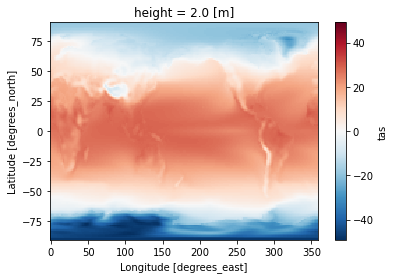

In [5]:
ds_avg.tas.plot(label="weighted")

In [6]:
# If you are interested in unweighted averages, simply specify `weighted=False`.
ds_avg_unweighted = ds.temporal.average("tas", weighted=False)

In [7]:
ds_avg_unweighted.tas

<xarray.DataArray 'tas' (lat: 145, lon: 192)>
array([[-48.014744, -48.014744, -48.014744, ..., -48.014744, -48.014744,
        -48.014744],
       [-44.940834, -44.979473, -45.018112, ..., -44.8241  , -44.862743,
        -44.900894],
       [-44.11878 , -44.230614, -44.33956 , ..., -43.767662, -43.885963,
        -44.003048],
       ...,
       [-18.210567, -18.174911, -18.139376, ..., -18.326977, -18.284075,
        -18.248377],
       [-18.507595, -18.492832, -18.478838, ..., -18.553926, -18.540533,
        -18.52393 ],
       [-19.073483, -19.073483, -19.073483, ..., -19.073483, -19.073483,
        -19.073483]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * lon      (lon) float64 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
    height   float64 2.0
Attributes:
    operation:     temporal_avg
    mode:          average
    freq:          month
    weighted:      False
    center_times:  False

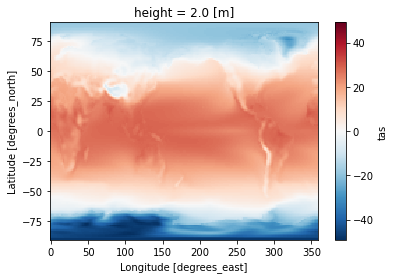

In [8]:
ds_avg.tas.plot(label="unweighted")

## 3. Calculate grouped averages

Related API: [xarray.Dataset.temporal.group_average()](../generated/xarray.Dataset.temporal.group_average.rst)

In this example, we will be calculating time weighted averages by group for the `tas` variable.

Helpful knowledge:

* Each specified frequency has predefined groups for grouping time coordinates.

  * The table below maps type of averages with its API frequency and grouping convention.

    | Type of Averages | API Frequency | Group By |
    |---	|---	|---	|
    | Yearly | ``freq=“year”`` | year 	|
    | Monthly | ``freq=“month”`` 	| year, month |
    | Seasonal | ``freq=“season”``  | year, season |
    | Custom seasonal 	| ``freq="season"`` and </br> ``season_config={"custom_seasons": <2D ARRAY>}``  | year, season 	|
    | Daily | ``freq=“day”`` | year, month, day |
    | Hourly | ``freq=“hour”`` | year, month, day, hour |

  * The grouping conventions are based on [CDAT/cdutil](https://github.com/CDAT/cdutil/blob/b823b69db46bb76536db7d435e72075fc3975c65/cdutil/times.py#L1620-L1640), except for daily and hourly means which aren't implemented in CDAT/cdutil.

* Masked (missing) data is automatically handled.
  * The weight of masked (missing) data are excluded when averages are calculated. This is the same as giving them a weight of 0.

### 3.1 Yearly Averages (`freq="year"`)

**Group time coordinates by year**

In [9]:
ds_yearly_avg = ds.temporal.group_average("tas", freq="year", weighted=True)

In [10]:
ds_yearly_avg.tas

<xarray.DataArray 'tas' (time: 165, lat: 145, lon: 192)>
array([[[-48.755733, -48.755733, -48.755733, ..., -48.755733,
         -48.755733, -48.755733],
        [-45.652065, -45.693024, -45.73506 , ..., -45.52128 ,
         -45.563866, -45.60669 ],
        [-44.775234, -44.905838, -45.03297 , ..., -44.37118 ,
         -44.50631 , -44.640503],
        ...,
        [-20.505976, -20.481321, -20.454565, ..., -20.588959,
         -20.557522, -20.530872],
        [-20.797592, -20.784252, -20.775455, ..., -20.83268 ,
         -20.823357, -20.807684],
        [-21.201149, -21.201149, -21.201149, ..., -21.201149,
         -21.201149, -21.201149]],

       [[-48.95255 , -48.95255 , -48.95255 , ..., -48.95255 ,
         -48.95255 , -48.95255 ],
        [-45.83191 , -45.864902, -45.89875 , ..., -45.73217 ,
         -45.76544 , -45.798595],
        [-44.935368, -45.037956, -45.13801 , ..., -44.61143 ,
         -44.71986 , -44.829372],
...
        [-14.916271, -14.899261, -14.88381 , ..., -14.99543 ,
         -14.965137, -14.938532],
        [-15.405922, -15.396681, -15.385955, ..., -15.432463,
         -15.426056, -15.413568],
        [-15.945   , -15.945   , -15.945   , ..., -15.945   ,
         -15.945   , -15.945   ]],

       [[-47.59732 , -47.59732 , -47.59732 , ..., -47.59732 ,
         -47.59732 , -47.59732 ],
        [-44.721367, -44.763428, -44.803505, ..., -44.592392,
         -44.634445, -44.678226],
        [-43.85032 , -43.969563, -44.08714 , ..., -43.4709  ,
         -43.596764, -43.72408 ],
        ...,
        [-14.52023 , -14.474079, -14.432307, ..., -14.675514,
         -14.620932, -14.567368],
        [-14.911236, -14.892309, -14.869016, ..., -14.982012,
         -14.962668, -14.938723],
        [-15.618406, -15.618406, -15.618406, ..., -15.618406,
         -15.618406, -15.618406]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * lon      (lon) float64 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
    height   float64 2.0
  * time     (time) datetime64[ns] 1850-01-01 1851-01-01 ... 2014-01-01
Attributes:
    operation:     temporal_avg
    mode:          group_average
    freq:          year
    weighted:      True
    center_times:  False

![tas yearly averages](../examples/temporal-average-yearly.gif)

*This GIF was created using [xmovie](https://github.com/jbusecke/xmovie).*

Sample ``xmovie`` code:
```python
import xmovie
mov = xmovie.Movie(ds_yearly_avg.tas)
mov.save("temporal-average-yearly.gif")
```

### 3.2 Seasonal Averages (`freq="season"`)

**Group time coordinates by year and season**

In [11]:
ds_season_avg = ds.temporal.group_average("tas", freq="season", weighted=True)

In [12]:
ds_season_avg.tas

<xarray.DataArray 'tas' (time: 661, lat: 145, lon: 192)>
array([[[-32.705883  , -32.705883  , -32.705883  , ..., -32.705883  ,
         -32.705883  , -32.705883  ],
        [-30.993767  , -31.037586  , -31.089327  , ..., -30.845623  ,
         -30.894127  , -30.94401   ],
        [-30.02515   , -30.145437  , -30.26419   , ..., -29.660372  ,
         -29.78108   , -29.902878  ],
        ...,
        [-37.72314   , -37.685493  , -37.654167  , ..., -37.8262    ,
         -37.790344  , -37.75683   ],
        [-38.274647  , -38.263725  , -38.250145  , ..., -38.292183  ,
         -38.290638  , -38.28456   ],
        [-38.743587  , -38.743587  , -38.743587  , ..., -38.743587  ,
         -38.743587  , -38.743587  ]],

       [[-54.290863  , -54.290863  , -54.290863  , ..., -54.290863  ,
         -54.290863  , -54.290863  ],
        [-51.117714  , -51.175236  , -51.230553  , ..., -50.935165  ,
         -50.99657   , -51.056145  ],
        [-50.318047  , -50.486664  , -50.649567  , ..., -49.79003   ,
         -49.970078  , -50.14521   ],
...
        [-12.342774  , -12.2246685 , -12.106632  , ..., -12.744922  ,
         -12.609088  , -12.478392  ],
        [-13.126404  , -13.066109  , -13.003876  , ..., -13.306077  ,
         -13.258715  , -13.19972   ],
        [-14.288469  , -14.288469  , -14.288469  , ..., -14.288469  ,
         -14.288469  , -14.288469  ]],

       [[-28.990494  , -28.990494  , -28.990494  , ..., -28.990494  ,
         -28.990494  , -28.990494  ],
        [-28.192917  , -28.224579  , -28.261307  , ..., -28.095932  ,
         -28.125992  , -28.15802   ],
        [-27.607407  , -27.705643  , -27.805115  , ..., -27.311615  ,
         -27.410828  , -27.508362  ],
        ...,
        [-24.256271  , -24.140594  , -24.037537  , ..., -24.61853   ,
         -24.488495  , -24.36644   ],
        [-24.629013  , -24.613388  , -24.549866  , ..., -24.752045  ,
         -24.721603  , -24.666412  ],
        [-25.28923   , -25.28923   , -25.28923   , ..., -25.28923   ,
         -25.28923   , -25.28923   ]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * lon      (lon) float64 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
    height   float64 2.0
  * time     (time) datetime64[ns] 1850-01-01 1850-04-01 ... 2015-01-01
Attributes:
    operation:            temporal_avg
    mode:                 group_average
    freq:                 season
    weighted:             True
    center_times:         False
    dec_mode:             DJF
    drop_incomplete_djf:  False

**Notice that the season of each time coordinate is represented by its middle month.**

- "DJF" is represented by month 1 ("J"/January)
- "MAM" is represented by month 4 ("A"/April)
- "JJA" is represented by month 7 ("J"/July)
- "SON" is represented by month 10 ("O"/October).

This is implementation design was used because `datetime` objects do not distinguish seasons, so the middle month is used instead.


In [13]:
ds_season_avg.time

<xarray.DataArray 'time' (time: 661)>
array(['1850-01-01T00:00:00.000000000', '1850-04-01T00:00:00.000000000',
       '1850-07-01T00:00:00.000000000', ..., '2014-07-01T00:00:00.000000000',
       '2014-10-01T00:00:00.000000000', '2015-01-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    height   float64 2.0
  * time     (time) datetime64[ns] 1850-01-01 1850-04-01 ... 2015-01-01
Attributes:
    bounds:         time_bnds
    axis:           T
    long_name:      time
    standard_name:  time
    _ChunkSizes:    1

### 3.3 Monthly Averages (`freq="month"`)

**Group time coordinates by year and month**

In [14]:
ds_monthly_avg = ds.temporal.group_average("tas", freq="month", weighted=True)

In [15]:
ds_monthly_avg.tas

<xarray.DataArray 'tas' (time: 1980, lat: 145, lon: 192)>
array([[[-27.186966 , -27.186966 , -27.186966 , ..., -27.186966 ,
         -27.186966 , -27.186966 ],
        [-25.952972 , -25.990189 , -26.04216  , ..., -25.809921 ,
         -25.856598 , -25.905975 ],
        [-24.976852 , -25.09407  , -25.20755  , ..., -24.622055 ,
         -24.738693 , -24.856827 ],
        ...,
        [-35.20546  , -35.180023 , -35.165436 , ..., -35.312057 ,
         -35.273193 , -35.239227 ],
        [-35.80052  , -35.79355  , -35.789337 , ..., -35.815628 ,
         -35.811234 , -35.81041  ],
        [-36.399933 , -36.399933 , -36.399933 , ..., -36.399933 ,
         -36.399933 , -36.399933 ]],

       [[-38.816116 , -38.816116 , -38.816116 , ..., -38.816116 ,
         -38.816116 , -38.816116 ],
        [-36.574646 , -36.62578  , -36.67726  , ..., -36.420868 ,
         -36.47139  , -36.521835 ],
        [-35.614334 , -35.73802  , -35.86261  , ..., -35.23851  ,
         -35.363724 , -35.48958  ],
...
        [-12.968658 , -12.7821045, -12.606537 , ..., -13.613556 ,
         -13.394165 , -13.176605 ],
        [-14.207672 , -14.1249695, -14.035736 , ..., -14.471008 ,
         -14.386902 , -14.306213 ],
        [-16.90924  , -16.90924  , -16.90924  , ..., -16.90924  ,
         -16.90924  , -16.90924  ]],

       [[-28.990494 , -28.990494 , -28.990494 , ..., -28.990494 ,
         -28.990494 , -28.990494 ],
        [-28.192917 , -28.224579 , -28.261307 , ..., -28.095932 ,
         -28.125992 , -28.15802  ],
        [-27.607407 , -27.705643 , -27.805115 , ..., -27.311615 ,
         -27.410828 , -27.508362 ],
        ...,
        [-24.256271 , -24.140594 , -24.037537 , ..., -24.61853  ,
         -24.488495 , -24.36644  ],
        [-24.629013 , -24.613388 , -24.549866 , ..., -24.752045 ,
         -24.721603 , -24.666412 ],
        [-25.28923  , -25.28923  , -25.28923  , ..., -25.28923  ,
         -25.28923  , -25.28923  ]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * lon      (lon) float64 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
    height   float64 2.0
  * time     (time) datetime64[ns] 1850-01-01 1850-02-01 ... 2014-12-01
Attributes:
    operation:     temporal_avg
    mode:          group_average
    freq:          month
    weighted:      True
    center_times:  False

*Since our sample data is already monthly, the number of time coordinates does not change (1980).* 

However, the day and hour values are dropped from the coordinates since they aren't used when groups are formed for averaging.

In [16]:
ds_monthly_avg.time

<xarray.DataArray 'time' (time: 1980)>
array(['1850-01-01T00:00:00.000000000', '1850-02-01T00:00:00.000000000',
       '1850-03-01T00:00:00.000000000', ..., '2014-10-01T00:00:00.000000000',
       '2014-11-01T00:00:00.000000000', '2014-12-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    height   float64 2.0
  * time     (time) datetime64[ns] 1850-01-01 1850-02-01 ... 2014-12-01
Attributes:
    bounds:         time_bnds
    axis:           T
    long_name:      time
    standard_name:  time
    _ChunkSizes:    1

### 3.4 Daily Averages(`freq="day"`)

**Group time coordinates by year, month, and day**

In [17]:
ds_daily_avg = ds.temporal.group_average("tas", freq="day", weighted=True)

In [18]:
ds_daily_avg.tas

<xarray.DataArray 'tas' (time: 1980, lat: 145, lon: 192)>
array([[[-27.186966 , -27.186966 , -27.186966 , ..., -27.186966 ,
         -27.186966 , -27.186966 ],
        [-25.952972 , -25.990189 , -26.04216  , ..., -25.809921 ,
         -25.856598 , -25.905975 ],
        [-24.976852 , -25.09407  , -25.20755  , ..., -24.622055 ,
         -24.738693 , -24.856827 ],
        ...,
        [-35.20546  , -35.180023 , -35.165436 , ..., -35.312057 ,
         -35.273193 , -35.239227 ],
        [-35.80052  , -35.79355  , -35.789337 , ..., -35.815628 ,
         -35.811234 , -35.81041  ],
        [-36.399933 , -36.399933 , -36.399933 , ..., -36.399933 ,
         -36.399933 , -36.399933 ]],

       [[-38.816116 , -38.816116 , -38.816116 , ..., -38.816116 ,
         -38.816116 , -38.816116 ],
        [-36.574646 , -36.62578  , -36.67726  , ..., -36.420868 ,
         -36.47139  , -36.521835 ],
        [-35.614334 , -35.73802  , -35.86261  , ..., -35.23851  ,
         -35.363724 , -35.48958  ],
...
        [-12.968658 , -12.7821045, -12.606537 , ..., -13.613556 ,
         -13.394165 , -13.176605 ],
        [-14.207672 , -14.1249695, -14.035736 , ..., -14.471008 ,
         -14.386902 , -14.306213 ],
        [-16.90924  , -16.90924  , -16.90924  , ..., -16.90924  ,
         -16.90924  , -16.90924  ]],

       [[-28.990494 , -28.990494 , -28.990494 , ..., -28.990494 ,
         -28.990494 , -28.990494 ],
        [-28.192917 , -28.224579 , -28.261307 , ..., -28.095932 ,
         -28.125992 , -28.15802  ],
        [-27.607407 , -27.705643 , -27.805115 , ..., -27.311615 ,
         -27.410828 , -27.508362 ],
        ...,
        [-24.256271 , -24.140594 , -24.037537 , ..., -24.61853  ,
         -24.488495 , -24.36644  ],
        [-24.629013 , -24.613388 , -24.549866 , ..., -24.752045 ,
         -24.721603 , -24.666412 ],
        [-25.28923  , -25.28923  , -25.28923  , ..., -25.28923  ,
         -25.28923  , -25.28923  ]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * lon      (lon) float64 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
    height   float64 2.0
  * time     (time) datetime64[ns] 1850-01-16 1850-02-15 ... 2014-12-16
Attributes:
    operation:     temporal_avg
    mode:          group_average
    freq:          day
    weighted:      True
    center_times:  False

*Since our sample data is monthly and the averaging frequency is more granular (``freq="day"``), the number of time coordinates does not change (1980).*

In [19]:
ds_daily_avg.time

<xarray.DataArray 'time' (time: 1980)>
array(['1850-01-16T00:00:00.000000000', '1850-02-15T00:00:00.000000000',
       '1850-03-16T00:00:00.000000000', ..., '2014-10-16T00:00:00.000000000',
       '2014-11-16T00:00:00.000000000', '2014-12-16T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    height   float64 2.0
  * time     (time) datetime64[ns] 1850-01-16 1850-02-15 ... 2014-12-16
Attributes:
    bounds:         time_bnds
    axis:           T
    long_name:      time
    standard_name:  time
    _ChunkSizes:    1

### 3.5 Hourly Averages(`freq="hour"`)

**Group time coordinates by year, month, day, and hour**

In [20]:
ds_hourly_avg = ds.temporal.group_average("tas", freq="hour", weighted=True)

In [21]:
ds_hourly_avg.tas

<xarray.DataArray 'tas' (time: 1980, lat: 145, lon: 192)>
array([[[-27.186966 , -27.186966 , -27.186966 , ..., -27.186966 ,
         -27.186966 , -27.186966 ],
        [-25.952972 , -25.990189 , -26.04216  , ..., -25.809921 ,
         -25.856598 , -25.905975 ],
        [-24.976852 , -25.09407  , -25.20755  , ..., -24.622055 ,
         -24.738693 , -24.856827 ],
        ...,
        [-35.20546  , -35.180023 , -35.165436 , ..., -35.312057 ,
         -35.273193 , -35.239227 ],
        [-35.80052  , -35.79355  , -35.789337 , ..., -35.815628 ,
         -35.811234 , -35.81041  ],
        [-36.399933 , -36.399933 , -36.399933 , ..., -36.399933 ,
         -36.399933 , -36.399933 ]],

       [[-38.816116 , -38.816116 , -38.816116 , ..., -38.816116 ,
         -38.816116 , -38.816116 ],
        [-36.574646 , -36.62578  , -36.67726  , ..., -36.420868 ,
         -36.47139  , -36.521835 ],
        [-35.614334 , -35.73802  , -35.86261  , ..., -35.23851  ,
         -35.363724 , -35.48958  ],
...
        [-12.968658 , -12.7821045, -12.606537 , ..., -13.613556 ,
         -13.394165 , -13.176605 ],
        [-14.207672 , -14.1249695, -14.035736 , ..., -14.471008 ,
         -14.386902 , -14.306213 ],
        [-16.90924  , -16.90924  , -16.90924  , ..., -16.90924  ,
         -16.90924  , -16.90924  ]],

       [[-28.990494 , -28.990494 , -28.990494 , ..., -28.990494 ,
         -28.990494 , -28.990494 ],
        [-28.192917 , -28.224579 , -28.261307 , ..., -28.095932 ,
         -28.125992 , -28.15802  ],
        [-27.607407 , -27.705643 , -27.805115 , ..., -27.311615 ,
         -27.410828 , -27.508362 ],
        ...,
        [-24.256271 , -24.140594 , -24.037537 , ..., -24.61853  ,
         -24.488495 , -24.36644  ],
        [-24.629013 , -24.613388 , -24.549866 , ..., -24.752045 ,
         -24.721603 , -24.666412 ],
        [-25.28923  , -25.28923  , -25.28923  , ..., -25.28923  ,
         -25.28923  , -25.28923  ]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * lon      (lon) float64 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
    height   float64 2.0
  * time     (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T12:00:00
Attributes:
    operation:     temporal_avg
    mode:          group_average
    freq:          hour
    weighted:      True
    center_times:  False

*Since our sample data is monthly and the averaging frequency is more granular (``freq="hour"``), the number of time coordinates does not change (1980).*

In [22]:
ds_hourly_avg.time

<xarray.DataArray 'time' (time: 1980)>
array(['1850-01-16T12:00:00.000000000', '1850-02-15T00:00:00.000000000',
       '1850-03-16T12:00:00.000000000', ..., '2014-10-16T12:00:00.000000000',
       '2014-11-16T00:00:00.000000000', '2014-12-16T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    height   float64 2.0
  * time     (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T12:00:00
Attributes:
    bounds:         time_bnds
    axis:           T
    long_name:      time
    standard_name:  time
    _ChunkSizes:    1